# **Import wymaganych bibliotek**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

#Wyświetlenie wersji bibliotek
print ("TensorFlow version: " + tf.__version__)
print ("Keras version:" + keras.__version__)

TensorFlow version: 2.4.0
Keras version:2.4.0


# **Omówienie wybranego zbioru danych** 
Zbiór danych składa się z około 27 tysięcy zdjęć, przedstawiających zdrowe komórki i komórki zarażone malarią. Celem będzie nauczenie modelu rozróżniania komórkek zarażonych malarią od komórek zdrowych. Model taki mógłby być wykorzystywany w medycynie jako pomoc w zdiagnoznowaniu choroby.

https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

# **Ustawienie stałych hiperparamerów**

In [ ]:
DATA_DIR = r'/content/drive/MyDrive/cell_images'
BATCH_SIZE = 256
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
SHUFFLE = True
VALIDATION_SPLIT = 0.2
EPOCHS = 48

# **Zdefiniowanie matrycy zamieszania dla wyników**

In [ ]:
def show_confusion_matrix(validations, predictions, num_classes):
    matrix = metrics.confusion_matrix(validations, predictions,)
    plt.figure(figsize=(num_classes, num_classes))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.invert_yaxis()
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# **Tworzenie zbioru danych i podział na zbiór danych treningowych, walidacyjnych i testowych**

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VALIDATION_SPLIT,
  subset="training",
  shuffle=SHUFFLE,
  seed=123,
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode="binary")

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VALIDATION_SPLIT,
  subset="validation",
  shuffle=SHUFFLE,
  seed=321,
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode="binary")

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VALIDATION_SPLIT,
  subset="validation",
  shuffle=SHUFFLE,
  seed=241,
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode="binary")

#Pobranie nazw klas
CLASS_NAMES=train_ds.class_names
#Pobranie liczby klas
NUM_CLASSES=len(CLASS_NAMES)
#Wyświetlenie nazw klas
print("Nazwy klas: " + str(CLASS_NAMES))

Found 27565 files belonging to 2 classes.
Using 22052 files for training.
Found 27565 files belonging to 2 classes.
Using 5513 files for validation.
Found 27565 files belonging to 2 classes.
Using 5513 files for validation.
Nazwy klas: ['Parasitized', 'Uninfected']


# **Skonfigurowanie zbioru danych pod kątem wydajności**


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Wyświetlenie przykładowych danych**

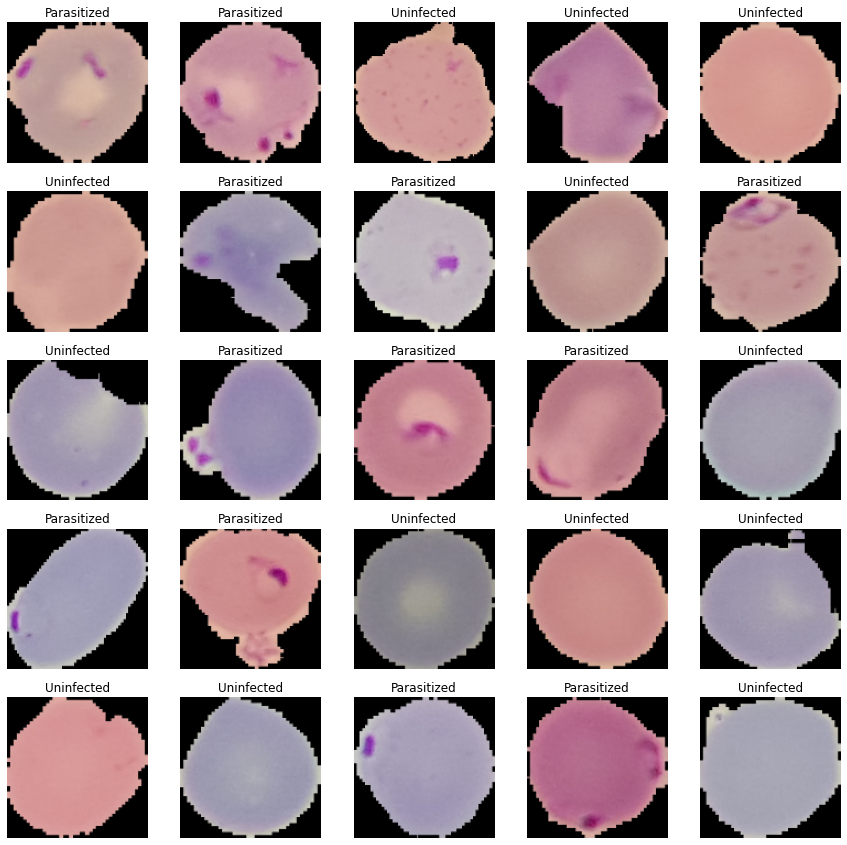

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(15, 15))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  index = int(label.numpy()[0])
  plt.title(CLASS_NAMES[index])
  plt.axis("off")

# **Utworzenie modelu struktury sieci uczącej**

In [ ]:
#Powiększenie zbioru danych
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.3),
  ]
)

model = Sequential([

  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1.0/255),

  #Utworzenie struktury sieci uczącej
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.3),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.2),

  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.3),

  layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.2),

  layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.3),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.3),

  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(1, activation='sigmoid')
])

#Utworzenie optymalizatora i ustawienie odpowiednich parametrów
opt = optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

#Skompilowanie modelu, podanie optymalizatora, wybranie funkcji straty, do której powinien dążyć model w procesie uczenia i funkcji używanej do oceny wydajności modelu
model.compile(
  optimizer=opt,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=['binary_accuracy'])

#Wyświetlenie podsumowania modelu sieci uczącej
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 32)       

# **Trenowanie modelu**

In [ ]:
#Zdefiniowanie redukcji szybkości uczenia się
learning_rate_reduction = ReduceLROnPlateau(monitor='val_binary_accuracy', 
                                            factor=0.5, 
                                            patience=EPOCHS, 
                                            verbose=1,  
                                            min_lr=0.0001) 

#Trenowanie modelu, wybranie danych, podanie liczby epok, wybranie przetasowywania danych, wywołania redukcji szybkości uczenia się, 
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    shuffle=SHUFFLE,
                    verbose=1,
                    callbacks=[learning_rate_reduction])

Epoch 1/48
87/87 [==============================] - 13s 135ms/step - loss: 0.8115 - binary_accuracy: 0.5197 - val_loss: 0.7170 - val_binary_accuracy: 0.5050
Epoch 2/48
87/87 [==============================] - 12s 133ms/step - loss: 0.6598 - binary_accuracy: 0.6167 - val_loss: 0.7189 - val_binary_accuracy: 0.5050
Epoch 3/48
87/87 [==============================] - 12s 134ms/step - loss: 0.6390 - binary_accuracy: 0.6495 - val_loss: 0.7212 - val_binary_accuracy: 0.5050
Epoch 4/48
87/87 [==============================] - 12s 135ms/step - loss: 0.6327 - binary_accuracy: 0.6599 - val_loss: 0.7208 - val_binary_accuracy: 0.5050
Epoch 5/48
87/87 [==============================] - 12s 136ms/step - loss: 0.6065 - binary_accuracy: 0.6877 - val_loss: 0.7749 - val_binary_accuracy: 0.5050
Epoch 6/48
87/87 [==============================] - 12s 136ms/step - loss: 0.4174 - binary_accuracy: 0.8401 - val_loss: 0.8593 - val_binary_accuracy: 0.5046
Epoch 7/48
87/87 [==============================] - 12s 13

# **Wizualizuj wyniki treningu**

Test loss: 0.12008973211050034
Test accuracy: 0.9604570865631104


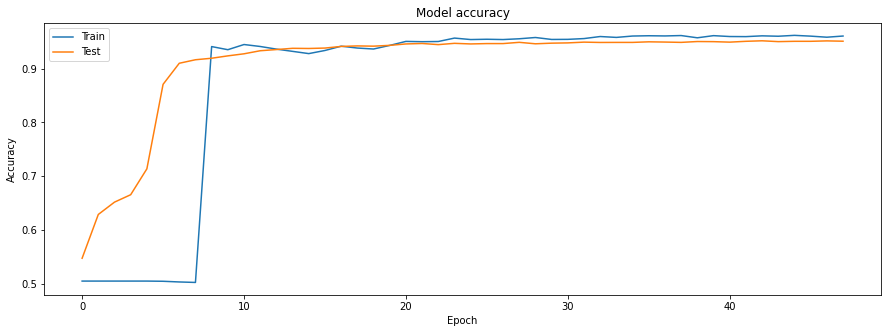

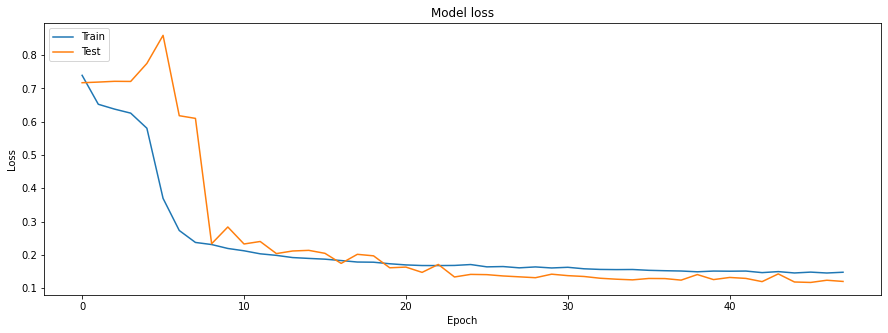

In [ ]:
#Ocena wytrenowanego modelu
score = model.evaluate(test_ds, verbose=0)
#Wyświetlenie straty i dokładności modelu  
print('Test loss:', score[0])     
print('Test accuracy:', score[1])  

#Wyświetlenie wykresu dla dokładności
plt.rcParams['figure.figsize'] = (15.0, 5.0) 
plt.plot(history.history['val_binary_accuracy']) 
plt.plot(history.history['binary_accuracy'])  
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Wyświetlenie wykresu dla straty
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc ='upper left')  
plt.show()

# **Użycie wytrenowanego modelu dla predykcji danych testowych. Wyświetlenie tablicy zamieszania i raportu klasyfikacji**

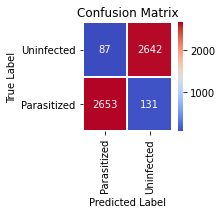

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      2784
         1.0       0.95      0.97      0.96      2729

    accuracy                           0.96      5513
   macro avg       0.96      0.96      0.96      5513
weighted avg       0.96      0.96      0.96      5513



In [ ]:
#Użycie wytrenowanego modelu do predykcji wartości
y_pred_test = model.predict(test_ds)

#Uzyskanie predykowanych wartości i wartości prawdziwych
predicted_categories = tf.where(y_pred_test < 0.5, 0, 1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

#Wyświetlenie tablicy zamieszania i raportu kalsyfikacji
show_confusion_matrix(true_categories, predicted_categories, NUM_CLASSES)
print(classification_report(true_categories, predicted_categories))


# **Wyświetlenie liczby źle sklasyfikowanych klas**

In [ ]:
#Obliczenie liczby źle sklasyfikowanych klas
classcheck = true_categories - predicted_categories.numpy()
misclassified = np.where(classcheck != 0)[0]
num_misclassified = len(misclassified)

#Wyświetlenie liczby źle sklasyfikowanych klas i przykładów.
size = len(true_categories)
print('Liczba wszystkich przypadków: ', size)
print('Liczba źle sklasyfikowanych przypadków: ', str(num_misclassified))
acc = (size - num_misclassified) / size * 100
print('Dokładność predykcji: ', acc)

Liczba wszystkich przypadków:  5513
Liczba źle sklasyfikowanych przypadków:  218
Dokładność predykcji:  96.04571013966986


# **Wyświetlenie przykładów źle sklasyfikowanych klas**

Przykłady źle sklasyfikowanych klas:


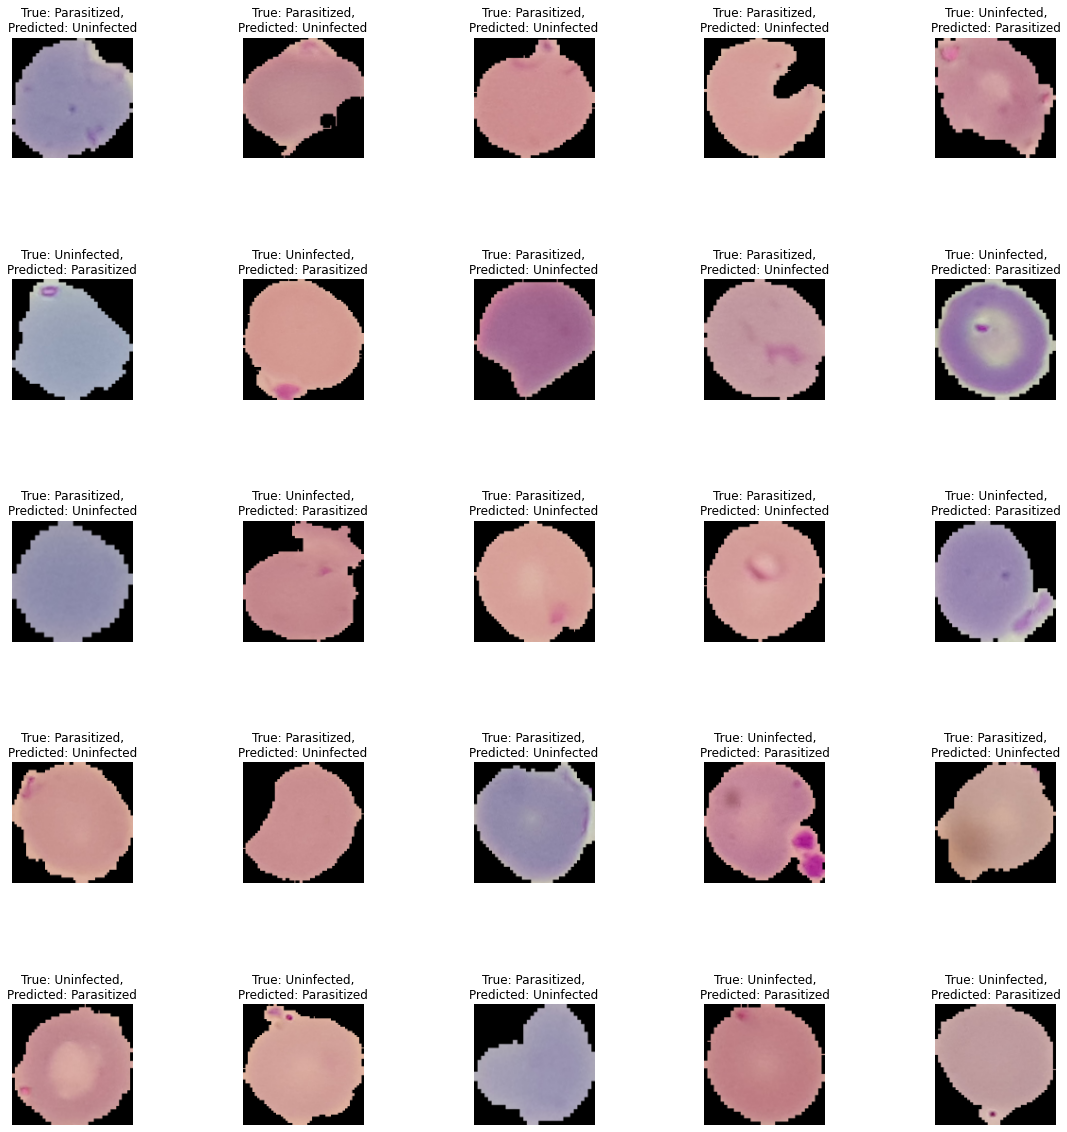

In [ ]:
#Deklaracja zmiennych, używanych przy wyświetlaniu
index = 0
i = 0
batch = -1

#Ustalenie rozmiaru
plt.figure(figsize=(20, 20))

print("Przykłady źle sklasyfikowanych klas:")

#Iteracja przez wszystkie batch'e w zbiorze testowym i wyświetlenie 25 źle sklasyfikowanych przykładów
for image_batch, label_batch in iter(test_ds):
  batch += 1
  if i > 25:
    break

  for index in range(BATCH_SIZE):
    if index + batch * BATCH_SIZE > size:
      break
    if i > 25:
      break
    if (index + batch * BATCH_SIZE) in misclassified:
      i += 1
      if i > 25:
        break
      ax = plt.subplot(5, 5, i)
      plt.subplots_adjust(hspace=1)
      plt.imshow(image_batch[index].numpy().astype("uint8"))
      label = label_batch[index]
      true_label = int(label.numpy()[0])
      predicted_label = int(predicted_categories.numpy()[index + batch * BATCH_SIZE])
      plt.title('True: ' + CLASS_NAMES[true_label] + ",\nPredicted: " + CLASS_NAMES[predicted_label])
      plt.axis("off")